In [1]:
from transformers import pipeline
import nltk
from nltk import sent_tokenize
import torch
import pandas as pd
import numpy as np

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Victus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [3]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else "cpu"

In [4]:
def load_model(device):
  theme_classifier = pipeline(
    "zero-shot-classification",
    model=model_name,
    device=device,
  )
  return theme_classifier

In [5]:
theme_classifier = load_model(device)

c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
theme_list = ["friendship", "hope", "sacrifice", "battle", "self development", "betrayal", "love", "dialogue"]

In [7]:
theme_classifier(
  "I gave him a right hook then a left job",
  theme_list, 
  multi_label=True
)

c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'sequence': 'I gave him a right hook then a left job',
 'labels': ['battle',
  'self development',
  'sacrifice',
  'betrayal',
  'hope',
  'dialogue',
  'friendship',
  'love'],
 'scores': [0.837052583694458,
  0.6021719574928284,
  0.1103336438536644,
  0.045419882982969284,
  0.038480550050735474,
  0.03672119602560997,
  0.005136561114341021,
  0.0022708855103701353]}

# Load The Dataset

In [8]:
from glob import glob

files = glob('../data/Subtitles/*.ass')

In [9]:
with open(files[0], 'r') as file:
  lines = file.readlines()
  lines = lines[27:]
  lines = [",".join(line.split(',')[9:]) for line in lines]

In [10]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [11]:
lines = [line.replace('\\N', ' ') for line in lines]

In [12]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [13]:
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [14]:
def load_subtitles_dataset(dataset_path):
  subtitles_path = glob(dataset_path + '/*.ass')
  
  scripts = []
  episode_num = []
  
  for path in subtitles_path:
    # read lines
    with open(path, 'r') as file:
      lines = file.readlines()
      lines = lines[27:]
      lines = [",".join(line.split(',')[9:]) for line in lines]
    
    # Clean them
    lines = [line.replace('\\N', ' ') for line in lines]
    script = " ".join(lines)
    
    episode = int(path.split('-')[-1].split('.')[0].strip())
    
    scripts.append(script)
    episode_num.append(episode)
  
  df = pd.DataFrame.from_dict({"episode": episode_num, "script": scripts})
  
  return df    

# Run Model

In [15]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [16]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [17]:
script = df.iloc[0]['script']
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [18]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [19]:
# Batch Sentence
sentence_batch_size = 20
script_batches = []

for index in range(0, len(script_sentences), sentence_batch_size):
  sent = " ".join(script_sentences[index:index+sentence_batch_size])
  script_batches.append(sent)

In [20]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [21]:
theme_output = theme_classifier(
  script_batches[:2],
  theme_list,
  multi_label=True
)
theme_output

c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x0000026DF78FBCA0> was reported to be 2(when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x0000026DF78FBCA0> was reported to be 2(when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x0000026DF78FBCA0> was reported to be 2(when accessing len(dataloader)), but 5 samples have 

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800738096237183,
   0.9396898746490479,
   0.8546876311302185,
   0.7349802851676941,
   0.7284942865371704,
   0.199098885059356

In [22]:
# Wrangle output
themes = {}
for output in theme_output:
  for label, score in zip(output['labels'], output['scores']):
    # print(f"{label}: {score:2f}")
    if label not in themes:
      themes[label] = []
    themes[label].append(score)

In [23]:
themes

{'dialogue': [0.9800738096237183, 0.9370123744010925],
 'betrayal': [0.9396898746490479, 0.6457238793373108],
 'battle': [0.8546876311302185, 0.6581296920776367],
 'sacrifice': [0.7349802851676941, 0.6258816123008728],
 'self development': [0.7284942865371704, 0.8678190112113953],
 'hope': [0.1990988850593567, 0.20424167811870575],
 'friendship': [0.05922325327992439, 0.08603297173976898],
 'love': [0.04026169702410698, 0.028020579367876053]}

In [24]:
def get_themes_inference(script):
  script_sentences = sent_tokenize(script)
  
  # Batch Sentence
  sentence_batch_size = 20
  script_batches = []

  for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)
  
  # Run Model
  theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
  )
  # Wrangle output
  themes = {}
  for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
      # print(f"{label}: {score:2f}")
      if label not in themes:
        themes[label] = []
      themes[label].append(score)
  
  themes = {key: np.mean(np.array(value)) for key, value in themes.items()}
    
  return themes

In [25]:
themes = {key: np.mean(np.array(value)) for key, value in themes.items()}
themes

{'dialogue': 0.9585430920124054,
 'betrayal': 0.7927068769931793,
 'battle': 0.7564086616039276,
 'sacrifice': 0.6804309487342834,
 'self development': 0.7981566488742828,
 'hope': 0.20167028158903122,
 'friendship': 0.07262811250984669,
 'love': 0.034141138195991516}

In [26]:
df = df.head(2) 
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [27]:
output_themes = df['script'].apply(get_themes_inference)

c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x0000026DF78FB0A0> was reported to be 2(when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x0000026DF78FB0A0> was reported to be 2(when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\Victus\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x0000026DF78FB0A0> was reported to be 2(when accessing len(dataloader)), but 5 samples have 

In [28]:
output_themes

0    {'dialogue': 0.9585430920124054, 'betrayal': 0...
1    {'dialogue': 0.9606055617332458, 'sacrifice': ...
Name: script, dtype: object

In [29]:
theme_df = pd.DataFrame(output_themes.tolist())

In [30]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792707,0.756409,0.680431,0.798157,0.201670,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.429944,0.684844,0.570702,0.482806,0.154534,0.046261,0.173261


# Visualization

In [31]:
df = df.drop('dialogue', axis=1)

In [34]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,betrayal,1.222651
1,battle,1.441253
2,sacrifice,1.251133
3,self development,1.280963
4,hope,0.356204
5,friendship,0.118889
6,love,0.207403


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

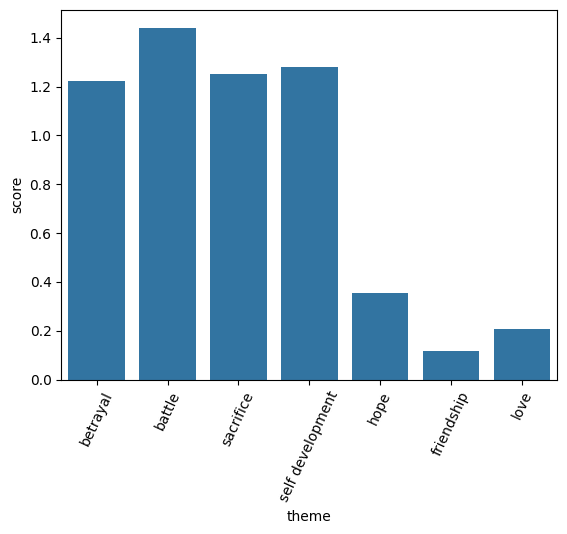

In [47]:
sns.barplot(data=theme_output, x='theme', y='score')
plt.xticks(rotation=65)
plt.show()